In [12]:
import os
import splitfolders
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [13]:
original_data_dir = 'dataset'
base_dir = 'split_dataset'

Divisão dos dados usando splitfolders

In [14]:
#if not os.path.exists(base_dir):
splitfolders.ratio (
    original_data_dir,
    output=base_dir,
    seed=42,
    ratio=(0.7, 0.15, 0.15),
    group_prefix=None,  # Opcional, mantém agrupamento de prefixos semelhantes
    move=False  # Copia os arquivos ao invés de movê-los
)

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

Geradores de dados com aumentação para treino

In [15]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

Gerando os dados a partir das imagens

In [16]:
batch_size = 32
image_size = (224, 224)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Não embaralhar para facilitar a avaliação
)

Found 303 images belonging to 4 classes.
Found 64 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


In [17]:
print(train_generator.class_indices)

{'Bacterial_dermatosis': 0, 'Fungal_infections': 1, 'Healthy': 2, 'Hypersensitivity_allergic_dermatosis': 3}


Modelo base InceptionV3 (pré-treinado no ImageNet)

In [18]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Congelar as camadas pré-treinadas

Construção do modelo

In [19]:
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)  # Aumentado o dropout para regularização
output = Dense(4, activation='softmax')(x)  # 4 classes

model = Model(inputs=base_model.input, outputs=output)

In [20]:
import PIL
print(PIL.__version__)

11.1.0


In [21]:
# Compilação do modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
checkpoint_cb = ModelCheckpoint(
    'best_model.keras', save_best_only=True, monitor='val_accuracy', mode='max'
)
early_stopping_cb = EarlyStopping(
    patience=10, restore_best_weights=True, monitor='val_loss'
)

# Treinamento
epochs = 50
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[checkpoint_cb, early_stopping_cb]
)

# Avaliação no conjunto de teste
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Acurácia no teste: {test_accuracy:.2f}")

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.3035 - loss: 6.2222 - val_accuracy: 0.2656 - val_loss: 2.1589
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.3735 - loss: 2.3138 - val_accuracy: 0.2969 - val_loss: 1.7328
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.4318 - loss: 1.4335 - val_accuracy: 0.3438 - val_loss: 1.4027
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.5614 - loss: 0.9947 - val_accuracy: 0.3906 - val_loss: 1.2717
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.6114 - loss: 0.9105 - val_accuracy: 0.3281 - val_loss: 1.2944
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.6343 - loss: 0.9061 - val_accuracy: 0.3438 - val_loss: 1.2678
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.6232 - loss: 0.8872 - val_accuracy: 0.3594 - val_loss: 1.2484
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6453 - loss: 0.7854 - val_accuracy: 0.3906 - val_loss:

Plotando os gráficos

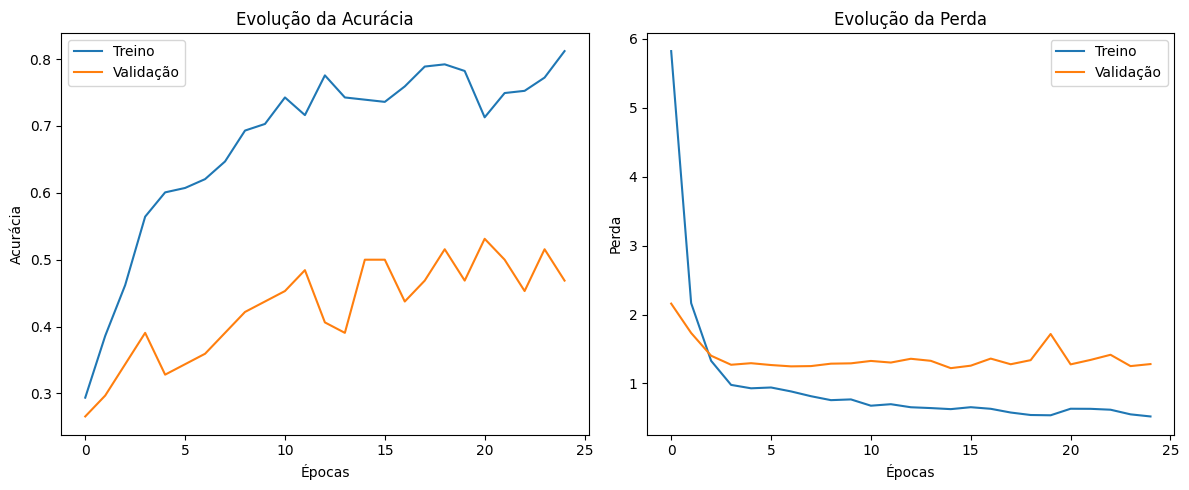

In [22]:
plt.figure(figsize=(12, 5))

# Acurácia
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.title('Evolução da Acurácia')

# Perda
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.title('Evolução da Perda')

plt.tight_layout()
plt.show()